# The Laplace Problem

In [23]:
%reset -f

In [24]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

import numpy as np
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')           ## CPU is faster here !

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks',
        font='sans-serif', font_scale=1, color_codes=True, rc={"lines.linewidth": 2})
import cmasher as cmr
plt.style.use("dark_background")

from updec import *
# from updec.operators import *
# from updec.utils import print_line_by_line, polyharmonic, multiquadric

key = jax.random.PRNGKey(42)

## Using Updec

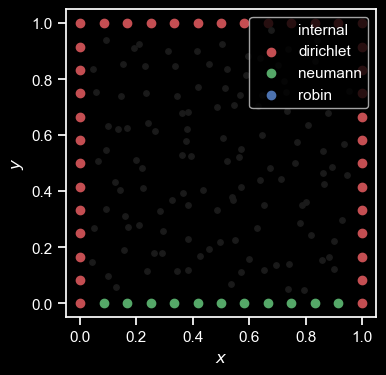

In [25]:
RBF = polyharmonic      ## Can define which rbf to use
MAX_DEGREE = 3

facet_types={"south":"n", "west":"d", "north":"d", "east":"d"}
size = 13
cloud = SquareCloud(Nx=size, Ny=size, facet_types=facet_types, noise_key=key, support_size=size*size-1)

# facet_types = {"Dirichlet":"d"}
# cloud = GmshCloud("./meshes/disk.msh", facet_types, support_size=20)

cloud.visualize_cloud(figsize=(4,4), cmap=cmr.amber);

In [26]:
print("\n=== Meshfree cloud for RBF method ===\n")
print()
print("Cloud bounding box: Nx =", cloud.Nx, " -  Ny =", cloud.Ny)
print()
# print("Boundary types (0=internal, 1=dirichlet, 2=neumann):\n", cloud.node_boundary_types)
print("Number of: \n\t-Internal points: Ni =", cloud.Ni, "\n\t-Dirichlet points: Md =", cloud.Nd, "\n\t-Neumann points: Mn =", cloud.Nn)
print("Surface types:\n", cloud.facet_types)
print()
print("Global indices:\n", cloud.global_indices)
print()
# # print("Global indices reversed:\n", cloud.global_indices_rev)
# # print()
print("Outward normals on Neumann/Robin boundaries:")
print_line_by_line(cloud.outward_normals)
# print()
# print("Node coordinates:", )
# print_line_by_line(cloud.nodes)
# print()
# print("Local supports (closest neighbours):")
# print_line_by_line(cloud.local_supports)


=== Meshfree cloud for RBF method ===


Cloud bounding box: Nx = 13  -  Ny = 13

Number of: 
	-Internal points: Ni = 121 
	-Dirichlet points: Md = 37 
	-Neumann points: Mn = 11
Surface types:
 {'south': 'n', 'west': 'd', 'north': 'd', 'east': 'd'}

Global indices:
 [[121 122 123 124 125 126 127 128 129 130 131 132 133]
 [158   0   1   2   3   4   5   6   7   8   9  10 134]
 [159  11  12  13  14  15  16  17  18  19  20  21 135]
 [160  22  23  24  25  26  27  28  29  30  31  32 136]
 [161  33  34  35  36  37  38  39  40  41  42  43 137]
 [162  44  45  46  47  48  49  50  51  52  53  54 138]
 [163  55  56  57  58  59  60  61  62  63  64  65 139]
 [164  66  67  68  69  70  71  72  73  74  75  76 140]
 [165  77  78  79  80  81  82  83  84  85  86  87 141]
 [166  88  89  90  91  92  93  94  95  96  97  98 142]
 [167  99 100 101 102 103 104 105 106 107 108 109 143]
 [168 110 111 112 113 114 115 116 117 118 119 120 144]
 [145 146 147 148 149 150 151 152 153 154 155 156 157]]

Outward normals 

In [27]:
## Operates on radial basis functions and polynomials at position x: don't forget the None. It is important!
# @jax.jit
# @partial(jax.jit, static_argnums=2)
def my_diff_operator(x, node=None, monomial=None, *args):
    return  nodal_laplacian(x, node, monomial, rbf=RBF)

# known_field = jnp.ones((cloud.N, ))

## Operates on entire fields at position x (inside node)
# @jax.jit
def my_rhs_operator(x):
    # return divergence(x, known_field, cloud, rbf=RBF, max_degree=2)
    # return -100.0
    return 0.0

d_north = lambda node: jnp.sin(jnp.pi * node[0])
# d_north2 = lambda node: 0.0
d_zero = lambda node: 0.0

boundary_conditions = {"south":d_zero, "west":d_zero, "north":d_north, "east":d_zero}

In [28]:
solution_field = pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)
# unknown_field

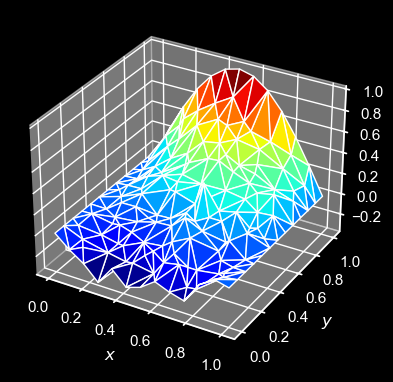

In [29]:
cloud.visualize_field(solution_field, cmap="jet", projection="3d", ax=None, figsize=(10,10));
# cloud.visualize_field(solution_field, cmap="viridis", projection="2d", ax=None, figsize=(6,5));

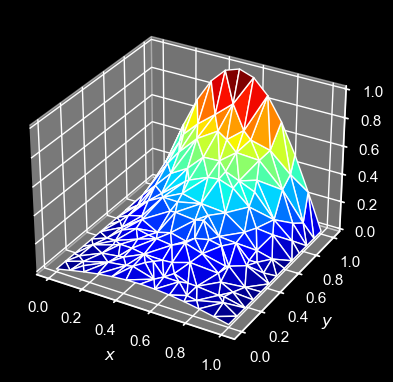

In [30]:
## Exact solution
coords = cloud.sort_nodes_jnp()

# exact_sol = jnp.zeros((cloud.N), dtype=jnp.float32)
def laplace_exact_sol(coord):
    # return jnp.cos(jnp.pi*coord[0])*jnp.sinh(jnp.pi*coord[1])
    # return 1 - (coord[0]**2 + coord[1]**2) / 4.     ## TODO Poisson a disk
    # return jnp.sin(jnp.pi*coord[0])*jnp.sinh(jnp.pi*coord[1]) / jnp.sinh(jnp.pi)
    return jnp.sin(jnp.pi*coord[0])*jnp.cosh(jnp.pi*coord[1]) / jnp.cosh(jnp.pi)

laplace_exact_sol = jax.vmap(laplace_exact_sol, in_axes=(0,), out_axes=0)

exact_sol = laplace_exact_sol(coords)

cloud.visualize_field(exact_sol, cmap="jet", projection="3d", ax=None, figsize=(10,10));
# ax, img = cloud.visualize_field(exact_sol, cmap="viridis", projection="2d", ax=None, figsize=(6,5), levels=50);

Error: 2.2013588


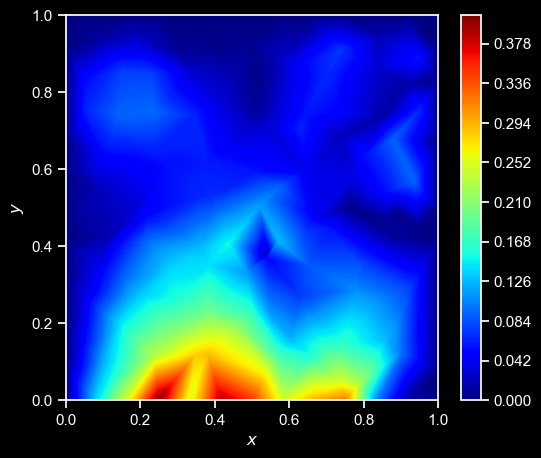

In [31]:
error = jnp.abs(exact_sol-solution_field)
print("Error:", jnp.sum(error**2))
# cloud.visualize_field(error, cmap="jet", projection="3d", ax=None, figsize=(10,10));
cloud.visualize_field(error, cmap="jet", projection="2d", ax=None, figsize=(6,5), levels=400);

In [32]:
# errors = []
# sizes = [4, 5, 7, 10, 12]
# for size in sizes:
#     cloud = SquareCloud(Nx=size, Ny=size, facet_types=facet_types, noise_key=key, support_size=size*size-1)
#     solution_field = pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)

#     coords = cloud.sort_nodes_jnp()
#     exact_sol = laplace_exact_sol(coords)

#     error = jnp.mean(jnp.abs(exact_sol-solution_field)**2)
#     print(f"Size: {size} \t Error: {error}")
#     errors.append(error)

In [33]:
# ax = plot(sizes, errors, "o-")
# ax.set_xscale('log')
# ax.set_yscale('log')

## Code profiling

In [34]:
# ### Profiling the code
# import cProfile
# cloud = Cloud(Nx=11, Ny=7, facet_types=facet_types, noise_seed=34)
# cProfile.run('pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)', filename=None, sort=2)